In [1]:

# LSTM model dummy
# Dummy model to predict the climate time series data

# !nvidia-smi

import tensorflow as tf 
# !pip install tensorflow-gpu
print(tf.__version__)

print('1: ', tf.config.list_physical_devices('GPU'))
print('2: ', tf.test.is_built_with_cuda)
print('3: ', tf.test.gpu_device_name())
print('4: ', tf.config.get_visible_devices())

2023-03-18 13:20:16.211656: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-18 13:20:16.329245: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-18 13:20:16.807146: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:/usr/include:/usr/lib/cuda/lib64::/home/abdul/miniconda3/env

2.11.0
1:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2:  <function is_built_with_cuda at 0x7f7388ae13a0>
3:  /device:GPU:0
4:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-03-18 13:20:17.415284: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-18 13:20:17.420580: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-18 13:20:17.420882: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-18 13:20:17.421634: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operati

In [2]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import pandas as pd
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, RepeatVector, TimeDistributed
import math
from sklearn.metrics import mean_squared_error

## Data Processing

### Data Fetching and Cleaning

In [3]:


# create a dataset of 30 sequences from the provided Data
def creatDataset(x,y,time_step):
    Xs, Ys = [],[]
    for i in range(len(x)-time_step):
        v = x.iloc[i:i+time_step].values
        Xs.append(v)
        Ys.append(x.iloc[i+time_step])
    return np.array(Xs),np.array(Ys)
    

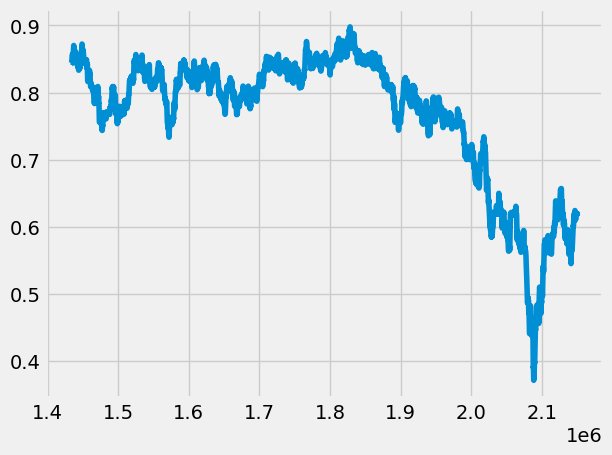

In [11]:
#getting data

scaler = MinMaxScaler()
df_normal = pd.read_csv('SynCAN/train_1.csv', delimiter=',')
df_normal_grp_ID1 = df_normal[df_normal['ID']=='id1'].dropna(axis=1, how='all')
df_normal_grp_ID1 = df_normal_grp_ID1.drop(df_normal_grp_ID1[['Label','ID']],axis =1)
# df_normal_grp_ID1 = df_normal_grp_ID1.iloc[0:(int(len(df_normal_grp_ID1)/5)),:]
df_normal_grp_ID1 = df_normal_grp_ID1.iloc[200000:300000,:]
df_normal_grp_ID1[['Time']] = scaler.fit_transform(df_normal_grp_ID1[['Time']])
# df_normal_grp_ID1
plt.plot(df_normal_grp_ID1['Signal1'])

In [5]:
df_normal_grp_ID1['Signal1']

1433404    0.842287
1433409    0.842287
1433419    0.842277
1433424    0.842257
1433432    0.842237
             ...   
4300129    0.281213
4300134    0.281884
4300142    0.282614
4300149    0.283465
4300157    0.284296
Name: Signal1, Length: 400000, dtype: float64

Text(0.5, 1.0, 'Plateau Attack (180000-190000) values')

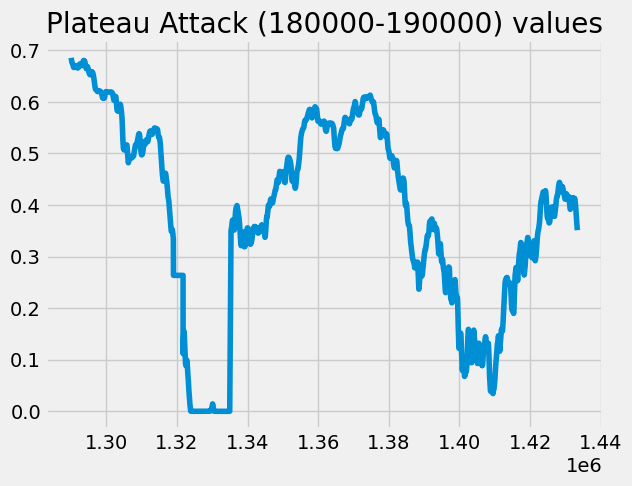

In [13]:
df_test_plat_ID1 = pd.read_csv('SynCAN/test_plateau.csv', delimiter=',')
df_test_plat_ID1 = df_test_plat_ID1[df_test_plat_ID1['ID']=='id1'].dropna(axis=1, how='all')
df_test_plat_ID1 = df_test_plat_ID1.drop(df_test_plat_ID1[['Label','ID']],axis =1)
# df_test_plat_ID1 = df_test_plat_ID1.iloc[0:(int(len(df_test_plat_ID1)/5)),:]
df_test_plat_ID1 = df_test_plat_ID1.iloc[180000:200000,:]
df_test_plat_ID1[['Time']] = scaler.fit_transform(df_test_plat_ID1[['Time']])

# df_test_plat_ID1.iloc[180000:250000,0:2]

# plt.plot(df_test_plat_ID1.iloc[180000:190000,1:2])
plt.plot(df_test_plat_ID1.iloc[:,1:2])
plt.title('Plateau Attack (180000-190000) values')

In [14]:
TIME_STEP = 30
X_train, Y_train = creatDataset(df_normal_grp_ID1[['Signal1']], df_normal_grp_ID1[['Signal1']], TIME_STEP)
X_test, Y_test = creatDataset(df_test_plat_ID1[['Signal1_of_ID']], df_test_plat_ID1[['Signal1_of_ID']], TIME_STEP)


In [15]:
Y_train.shape

# X_test.shape

(99970, 1)

### LSTM AUTOENCODER
#### Model Desgin

In [16]:


# n_features = X_train.shape[2]
model= Sequential()
model.add(LSTM(128, activation = 'relu', 
input_shape =(X_train.shape[1],X_train.shape[2]), return_sequences = True))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(RepeatVector(TIME_STEP))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 30, 128)           66560     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 repeat_vector_1 (RepeatVect  (None, 30, 64)           0         
 or)                                                             
                                                                 
 lstm_6 (LSTM)               (None, 30, 64)            33024     
                                                                 
 lstm_7 (LSTM)               (None, 30, 128)           98816     
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 1)            129       
 tributed)                                            

#### Model Fitting

In [24]:
# fit model
model.fit(X_train, Y_train, epochs=5, batch_size=30, validation_split=0.1, shuffle=False)
model.save("single_ID_LSTM_autoenc_old")

Epoch 1/5
3000/3000 [==============================] - 305s 102ms/step - loss: 0.0085 - val_loss: 0.0603
Epoch 2/5
3000/3000 [==============================] - 461s 154ms/step - loss: 0.0118 - val_loss: 0.0596
Epoch 3/5
3000/3000 [==============================] - 1072s 357ms/step - loss: 0.0115 - val_loss: 0.0601
Epoch 4/5
3000/3000 [==============================] - 1428s 476ms/step - loss: 0.0121 - val_loss: 0.0610
Epoch 5/5
 190/3000 [>.............................] - ETA: 28:07 - loss: 0.0671

KeyboardInterrupt: 

#### Training loss, finding Threshold

In [ ]:
reconstructed_model = keras.models.load_model("single_ID_LSTM_autoenc_old")
x_train_predict = reconstructed_model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(x_train_predict - X_train), axis=1)
sns.set(rc={'figure.figsize':(20,8.27)})
sns.distplot(train_mae_loss,bins=100,kde=True)
plt.savefig('training_loss.png')


ValueError: in user code:

    File "/home/abdul/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/home/abdul/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/abdul/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/home/abdul/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/home/abdul/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/abdul/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 2, 30, 1), found shape=(None, 30, 1)


### Test Loss

(19970,)

(295909, 1)


/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

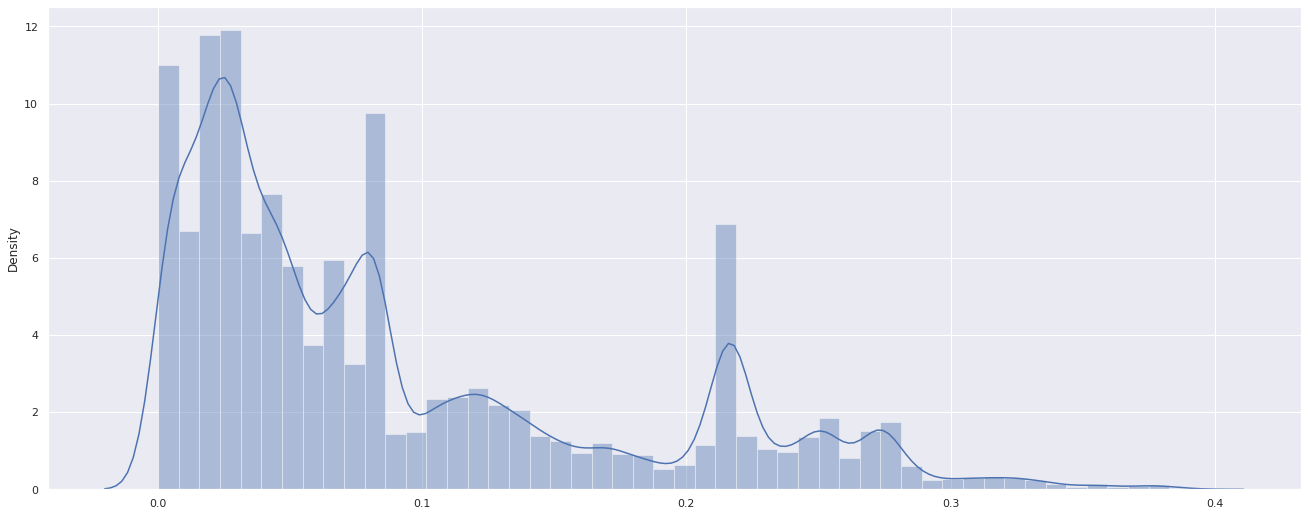

In [ ]:
THRESHOLD = 0.45

x_test_predict = reconstructed_model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(x_test_predict - X_test), axis=1)
print(test_mae_loss.shape)

sns.distplot(test_mae_loss,bins=50,kde=True )

### Test Score Dataframe Creation and plotting


In [23]:
print(df_test_plat_ID1[TIME_STEP:].index.shape)
print(test_mae_loss.shape)

(19970,)


NameError: name 'test_mae_loss' is not defined

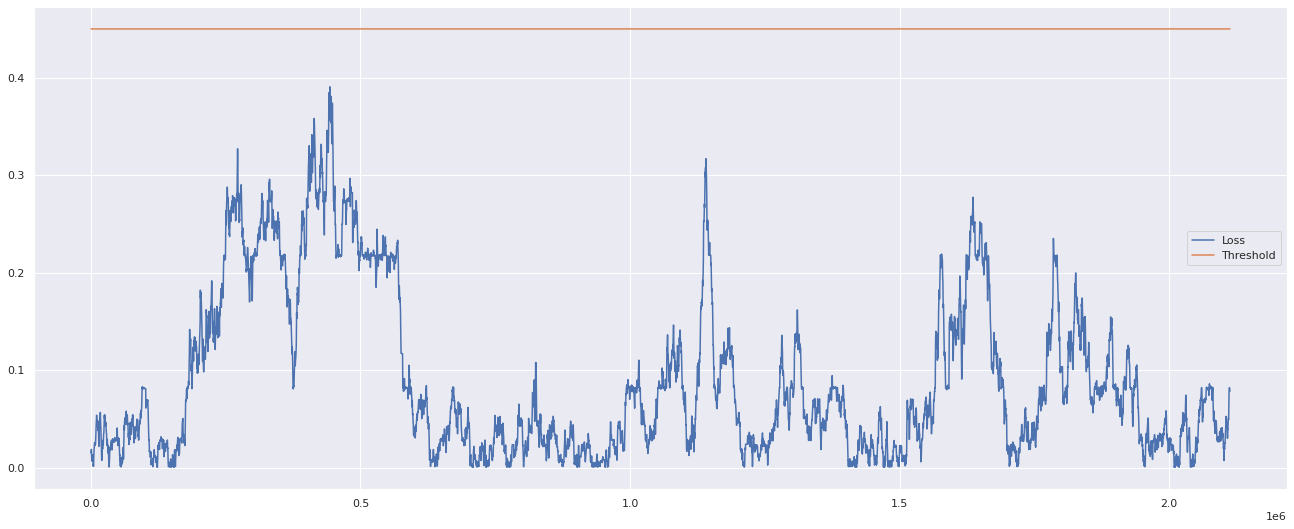

In [ ]:
test_score_df = pd.DataFrame(index=df_test_plat_ID1[TIME_STEP:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['Signal1'] = df_test_plat_ID1[TIME_STEP:].Signal1_of_ID

#plot the threshoold vs the actual loss values
plt.plot(test_score_df.index, test_score_df.loss, label='Loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='Threshold')
plt.legend()


# df['meantemp'].plot()
# df['humidity'].plot()
# plt.legend(['Sig1','Sig2'])

# train_set=df[:'2016'].iloc[:,0]
# test_set=df['2016':].iloc[:,0]
# df_normal_grp_ID1['Signal1_of_ID'].head()
# plt.plot(df_normal_grp_ID1['Time'],df_normal_grp_ID1['Signal1_of_ID'])
# df_normal_grp_ID1 = df_normal_grp_ID1.iloc[0:500,:]
# fig = 
# len(df_normal_grp_ID1)
# df_normal_grp_ID1['Signal1'].plot()

In [ ]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,Signal1


In [ ]:
df_test_plat_ID1.head

<bound method NDFrame.head of              Time  Signal1_of_ID  Signal2_of_ID
5        0.000000       0.760648           0.00
13       0.000003       0.760718           0.25
20       0.000007       0.760758           0.50
26       0.000010       0.760798           0.75
35       0.000013       0.760848           1.00
...           ...            ...            ...
2575768  0.999987       0.621343           0.75
2575775  0.999990       0.621384           1.00
2575783  0.999993       0.621403           0.00
2575790  0.999997       0.621414           0.25
2575796  1.000000       0.621414           0.50

[342827 rows x 3 columns]>

/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


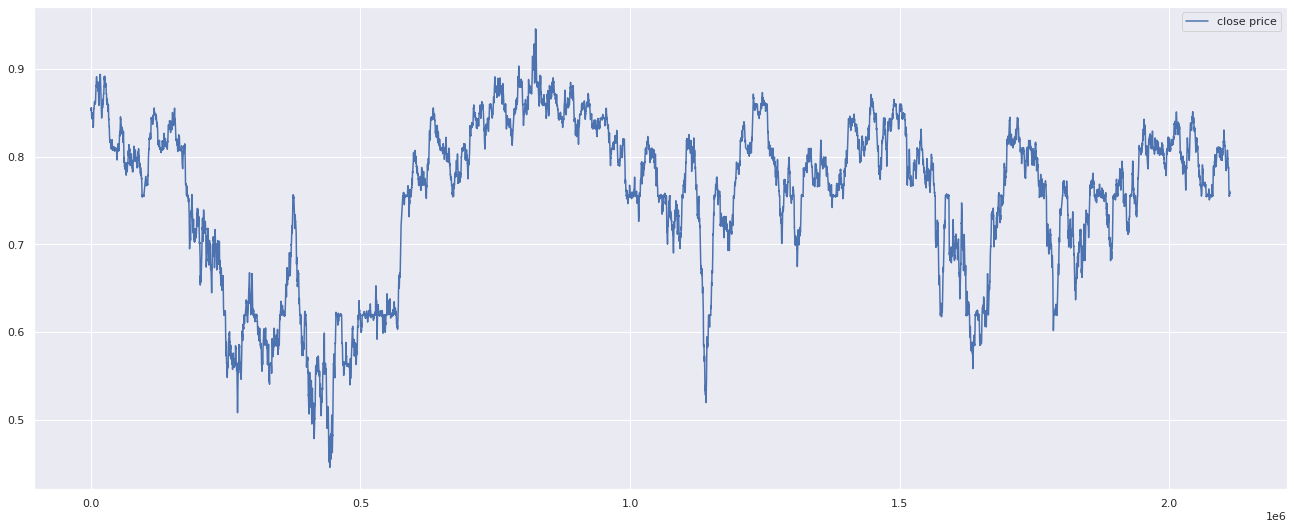

In [ ]:
plt.plot(
  df_test_plat_ID1[TIME_STEP:].index, 
  df_test_plat_ID1[TIME_STEP:].Signal1_of_ID, 
  label='close price'
);

sns.scatterplot(
  anomalies.index,
  anomalies.Signal1,
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.legend();